In [83]:
!pip install -r requirements.txt

In [96]:
import gym
import numpy as np
import random
from timeit import default_timer as timer
from datetime import timedelta
import matplotlib.pylab as plt
import pandas as pd
import seaborn as sns
from gym.envs.toy_text.frozen_lake import generate_random_map, FrozenLakeEnv
np.random.seed(123)

In [97]:
# defining grids

In [112]:

sixteen_grid = generate_random_map(16)
#
GRIDS = {
    "4x4": ['SHFF', 'FFFF', 'FFFH', 'FHFG'],
    "16x16": sixteen_grid 
}

In [42]:
four_grid

['SHFF', 'FFHF', 'FFFF', 'FFFG']

In [99]:
def grid_normalize(grid_type):
    size = len(grid_type)
    dis_map = np.zeros((size,size))
    for i, row in enumerate(grid_type):
        for j, loc in enumerate(row):
            if loc == "S":
                dis_map[i, j] = 0
            elif loc == "F":
                dis_map[i, j] = 0
            elif loc == "H":
                dis_map[i, j] = -1
            elif loc == "G":
                dis_map[i, j] = 1
    return dis_map


def policy_numpy(policy):
    size = int(np.sqrt(len(policy)))
    pol = np.asarray(policy)
    pol = pol.reshape((size, size))
    return pol


def grid_policy_visualizer(grid_size, policy):
    map_name = str(grid_size)+"x"+str(grid_size)
    data = grid_normalize(GRIDS[map_name])
    np_pol = policy_numpy(policy)
    plt.imshow(data, interpolation="nearest")

    for i in range(np_pol[0].size):
        for j in range(np_pol[0].size):
            arrow = '\u2190'
            if np_pol[i, j] == 1:
                arrow = '\u2193'
            elif np_pol[i, j] == 2:
                arrow = '\u2192'
            elif np_pol[i, j] == 3:
                arrow = '\u2191'
            text = plt.text(j, i, arrow,
                           ha="center", va="center", color="w")
    plt.show()


In [100]:
def policy_check(environment, policy, n_epoch=1000):
    rewards = []
    eps_cnt = []
    for i in range(n_epoch):
        curr_s = environment.reset()
        ep = 0
        done = False
        eps_reward = 0
        while not done and ep < 1000:
            ep += 1
            act = int(policy[curr_s])
            new_s, reward, done, _ = environment.step(act)
            eps_reward += reward
            curr_s = new_s

        rewards.append(eps_reward)
        eps_cnt.append(ep)
    
    # all done
    avg_reward = sum(rewards)/len(rewards)
    avg_eps = sum(eps_cnt)/len(eps_cnt)
    return avg_reward, avg_eps, rewards, eps_cnt 

In [101]:
# value iteration model 

In [102]:
def vi_model(environment, disc=0.9, epsilon=1e-12):
    
    start = timer()
    
    num_states = environment.observation_space.n
    num_action = environment.action_space.n
    policy = np.zeros((1, num_states))
    val_list = np.zeros((1, num_states))
    old_val_list = val_list.copy()
    eps = 0
    max_change = 1
    sigma = disc
    while max_change > epsilon:
        eps += 1
        for s in range(num_states):
            assig_val = -np.inf
            for a in range(num_action):
                tot_cand_val = 0
                for prob, new_s, reward, done in environment.P[s][a]:

                    value_new_s = old_val_list[0][new_s]
                    cand_value = 0
                    if done:
                        cand_value = reward 
                    else:
                        cand_value = reward + sigma*value_new_s
                    tot_cand_val += cand_value*prob 
                        
                if tot_cand_val > assig_val:
                    assig_val = tot_cand_val
                    policy[0][s] = a
                    val_list[0][s] = assig_val
        changes = np.abs(val_list - old_val_list)
        max_change = np.max(changes)
        old_val_list = val_list.copy()
        
    end = timer()
    time_spent = timedelta(seconds=end-start)
    print("converged in: {} episodes and {} seconds".format(eps, time_spent))
    return policy[0], eps, time_spent

In [103]:
# policy iteration model 

In [104]:
def pi_model(environment, disc=0.9, epsilon=1e-3):
    
    start = timer()
    
    num_states = environment.observation_space.n
    num_action = environment.action_space.n
    ## 1
    policy = np.random.randint(num_action, size=(1,num_states))
    val_list = np.zeros((1, num_states))
    eps = 0
    sigma = disc
    policy_state = False
    while not policy_state:
        eps += 1
        eval_acc = True
        while eval_acc:
            eps = 0
            for s in range(num_states):
                v = val_list[0][s]
                a = policy[0][s]
                total_val_new_s = 0
                for prob, new_s, reward, done in environment.P[s][a]:
                    value_new_s = val_list[0][new_s]
                    cand_value = 0
                    if done:
                        cand_value = reward                     
                    else:
                        cand_value = reward + sigma*value_new_s
                    total_val_new_s += cand_value*prob 
                val_list[0][s] = total_val_new_s
                    
                eps = max(eps, np.abs(v-val_list[0][s]))
            if eps < epsilon:
                eval_acc = False
        policy_state = True
        for s in range(num_states):
            old_action = policy[0][s]
            max_value = -np.inf
            for a in range(num_action):
                # get the new value 
                tot_cand_val = 0
                for prob, new_s, reward, done in environment.P[s][a]:
                    value_new_s = val_list[0][new_s]
                    cand_value = 0
                    if done:
                        cand_value = reward
                    else:
                        cand_value = reward + sigma*value_new_s
                    tot_cand_val += prob*cand_value
                if tot_cand_val > max_value:
                    max_value = tot_cand_val
                    policy[0][s] = a
            if old_action != policy[0][s]:
                policy_state = False
    
    
    end = timer()
    time_spent = timedelta(seconds=end-start)
    print("converged in: {} episodes and {} seconds".format(eps, time_spent))
    return policy[0], eps, time_spent
        

In [105]:
def run_pi_vi_policy(environment, disc=[0.9], epsilon=[1e-9], verbose=False):
    
    vi_dic = {}
    
    for dis in disc:
        vi_dic[dis] = {}
        for eps in epsilon:
            vi_dic[dis][eps] = {}
            
            # run value iteration
            vi_policy, vi_iter_solved, vi_time_taken = vi_model(environment, dis, eps)
            vi_avg_rewards, vi_avg_eps, _, __ = policy_check(environment, vi_policy)    
            vi_dic[dis][eps]["avg_reward"] = vi_avg_rewards
            vi_dic[dis][eps]["avg_eps"] = vi_avg_eps
            vi_dic[dis][eps]["iteration"] = vi_iter_solved
            vi_dic[dis][eps]["time_spent"] = vi_time_taken
            vi_dic[dis][eps]["policy"] = vi_policy
            if not verbose:
                print("Value iteration for {} disc and {} eps is done".format(dis, eps))
                print("Iteration: {} time: {}".format(vi_iter_solved, vi_time_taken))
                print("Average reward: {} - Average episodes: {}".format(vi_avg_rewards, vi_avg_eps))
    # run policy iteration
    pi_dic = {}
    for dis in disc:
        pi_dic[dis] = {}
        for eps in epsilon:
            pi_dic[dis][eps] = {}

            pi_policy, pi_iter_solved, pi_time_taken = pi_model(environment, dis, eps)
            pi_avg_rewards, pi_avg_eps, _, __ = policy_check(environment, pi_policy)    
            pi_dic[dis][eps]["avg_reward"] = pi_avg_rewards
            pi_dic[dis][eps]["avg_eps"] = pi_avg_eps
            pi_dic[dis][eps]["iteration"] = pi_iter_solved
            pi_dic[dis][eps]["time_spent"] = pi_time_taken
            pi_dic[dis][eps]["policy"] = pi_policy
            if not verbose:
                print("Policy iteration for {} disc is done".format(dis))
                print("Iteration: {} time: {}".format(pi_iter_solved, pi_time_taken))
                print("Average reward: {} - Average episodes: {}".format(pi_avg_rewards, pi_avg_eps))

    
    return vi_dic, pi_dic

In [204]:
def ploting_parameters(dictionary, value="Score", size=4, variable="discount Rate", log=False):
    sns.set_palette("pastel")
    plt.figure(figsize=(12, 8))
    title = "Average {} on {}x{} Frozen Lake".format(value, size, size)
    the_val = value
    value = "Average {}".format(the_val)
    val_type = "Total Reward".format(the_val)
    the_df = pd.DataFrame(columns=[variable, value, val_type])
    for k, v in dictionary.items():
        for val in v:
            if not log:
                dic = {variable: k, value: float(val), val_type: "Mean with std"}
            else:
                dic = {variable: np.log10(k), value: float(val), val_type: "Mean with std"}                
            the_df = the_df.append(dic, ignore_index=True)
        the_df = the_df.append(dic, ignore_index=True)
    sns.lineplot(x=variable, y=value, hue=val_type, style=val_type, markers=True, data=the_df).set(title=title)

In [160]:
def normalize_dict(the_dict):
    

    disc_rewards = {}
    disc_iterations = {}
    disc_times = {}


    for disc in the_dict:
        disc_rewards[disc] = []    
        disc_iterations[disc] = []    
        disc_times[disc] = []

        for eps in the_dict[disc]:
            disc_rewards[disc].append(the_dict[disc][eps]['avg_reward'])
            disc_iterations[disc].append(the_dict[disc][eps]['iteration'])        
            disc_times[disc].append(the_dict[disc][eps]['time_spent'].total_seconds())  

            
    epsilon_rewards = {}
    epsilon_iterations = {}
    epsilon_times = {}
    for eps in the_dict[0.5]:
        epsilon_rewards[eps] = []    
        epsilon_iterations[eps] = []    
        epsilon_times[eps] = []
    
        for disc in vi_dic:
            epsilon_rewards[eps].append(the_dict[disc][eps]['avg_reward'])
            epsilon_iterations[eps].append(the_dict[disc][eps]['iteration'])        
            epsilon_times[eps].append(the_dict[disc][eps]['time_spent'].total_seconds()) 
            
    return disc_rewards, disc_iterations, disc_times, epsilon_rewards, epsilon_iterations, epsilon_times

## 4x4

In [113]:
environment = gym.make("FrozenLake-v0")
vi_dic, pi_dic = run_pi_vi_policy(environment, disc=[0.5, 0.75, 0.9, 0.95, 0.99, 0.9999], 
                                        epsilon=[1e-3, 1e-6, 1e-9, 1e-12, 1e-15], verbose=True)

converged in: 7 episodes and 0:00:00.001863 seconds
converged in: 16 episodes and 0:00:00.003269 seconds
converged in: 25 episodes and 0:00:00.005024 seconds
converged in: 34 episodes and 0:00:00.006891 seconds
converged in: 44 episodes and 0:00:00.009137 seconds
converged in: 12 episodes and 0:00:00.004072 seconds
converged in: 33 episodes and 0:00:00.007265 seconds
converged in: 53 episodes and 0:00:00.011953 seconds
converged in: 73 episodes and 0:00:00.015597 seconds
converged in: 94 episodes and 0:00:00.020484 seconds
converged in: 27 episodes and 0:00:00.005624 seconds
converged in: 78 episodes and 0:00:00.016963 seconds
converged in: 129 episodes and 0:00:00.023926 seconds
converged in: 179 episodes and 0:00:00.039073 seconds
converged in: 230 episodes and 0:00:00.047451 seconds
converged in: 44 episodes and 0:00:00.009339 seconds
converged in: 128 episodes and 0:00:00.025547 seconds
converged in: 213 episodes and 0:00:00.041601 seconds
converged in: 297 episodes and 0:00:00.059

In [114]:
vi_dic[0.99]

{0.001: {'avg_reward': 0.758,
  'avg_eps': 45.846,
  'iteration': 105,
  'time_spent': datetime.timedelta(microseconds=20725),
  'policy': array([0., 3., 3., 3., 0., 0., 0., 0., 3., 1., 0., 0., 0., 2., 1., 0.])},
 1e-06: {'avg_reward': 0.756,
  'avg_eps': 45.733,
  'iteration': 305,
  'time_spent': datetime.timedelta(microseconds=63521),
  'policy': array([0., 3., 3., 3., 0., 0., 0., 0., 3., 1., 0., 0., 0., 2., 1., 0.])},
 1e-09: {'avg_reward': 0.739,
  'avg_eps': 42.957,
  'iteration': 504,
  'time_spent': datetime.timedelta(microseconds=109324),
  'policy': array([0., 3., 3., 3., 0., 0., 0., 0., 3., 1., 0., 0., 0., 2., 1., 0.])},
 1e-12: {'avg_reward': 0.723,
  'avg_eps': 44.083,
  'iteration': 704,
  'time_spent': datetime.timedelta(microseconds=152634),
  'policy': array([0., 3., 3., 3., 0., 0., 0., 0., 3., 1., 0., 0., 0., 2., 1., 0.])},
 1e-15: {'avg_reward': 0.731,
  'avg_eps': 44.189,
  'iteration': 903,
  'time_spent': datetime.timedelta(microseconds=185673),
  'policy': array(

In [115]:
pi_dic[0.9999]

{0.001: {'avg_reward': 0.74,
  'avg_eps': 44.43,
  'iteration': 0.0009824363083776877,
  'time_spent': datetime.timedelta(microseconds=17262),
  'policy': array([0, 3, 3, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0])},
 1e-06: {'avg_reward': 0.724,
  'avg_eps': 44.582,
  'iteration': 9.916084623418087e-07,
  'time_spent': datetime.timedelta(microseconds=71448),
  'policy': array([0, 3, 3, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0])},
 1e-09: {'avg_reward': 0.743,
  'avg_eps': 43.644,
  'iteration': 9.820118052061844e-10,
  'time_spent': datetime.timedelta(microseconds=94894),
  'policy': array([0, 3, 3, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0])},
 1e-12: {'avg_reward': 0.73,
  'avg_eps': 44.865,
  'iteration': 9.726663918740996e-13,
  'time_spent': datetime.timedelta(microseconds=198586),
  'policy': array([0, 3, 3, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1, 0])},
 1e-15: {'avg_reward': 0.728,
  'avg_eps': 44.215,
  'iteration': 9.992007221626409e-16,
  'time_spent': datetime.timedelta(microseconds=22013

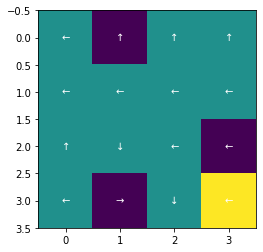

In [116]:
pol = vi_dic[0.99][1e-12]['policy']
value_grid4 = normalize_dict(vi_dic)
grid_policy_visualizer(4, pol)

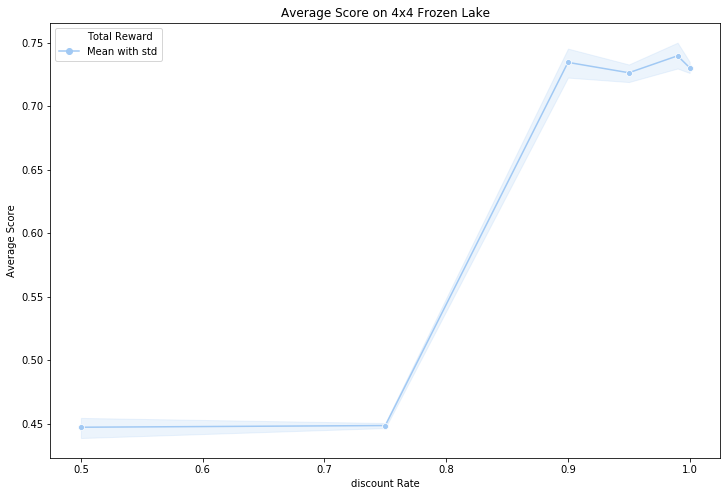

In [205]:
ploting_parameters(value_grid4[0], value="Score", size=4)

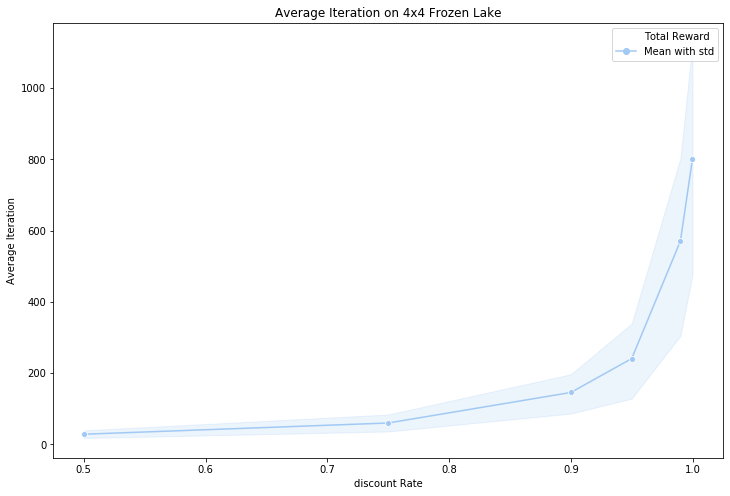

In [206]:
ploting_parameters(value_grid4[1], value="Iteration", size=4)

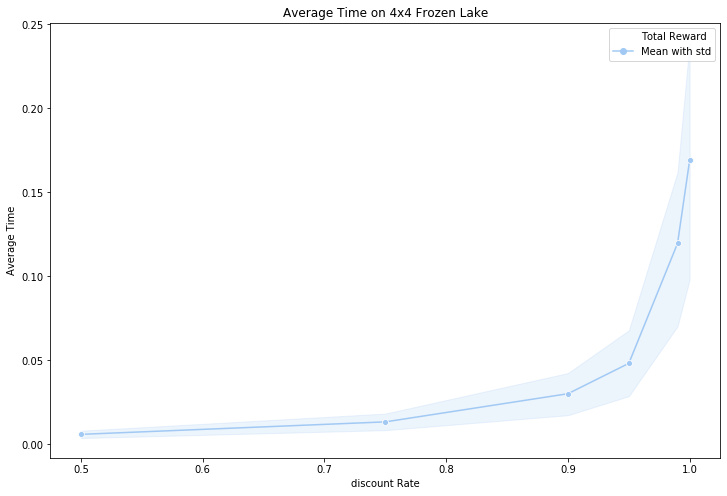

In [207]:
ploting_parameters(value_grid4[2], value="Time", size=4)

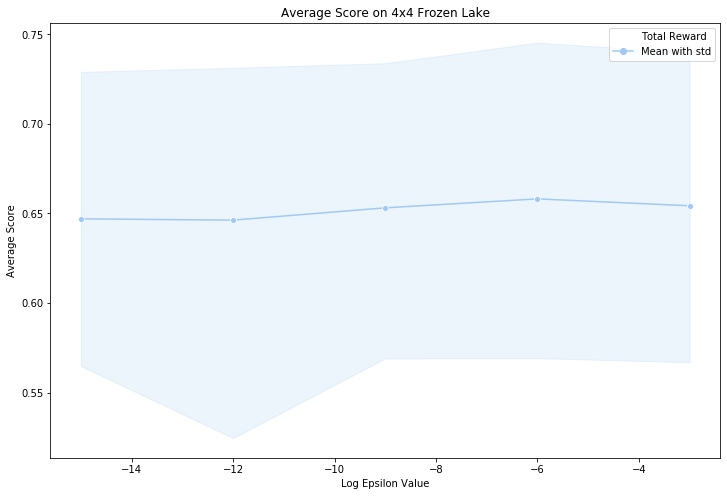

In [208]:
ploting_parameters(value_grid4[3], value="Score", size=4, variable="Log Epsilon Value", log=True)

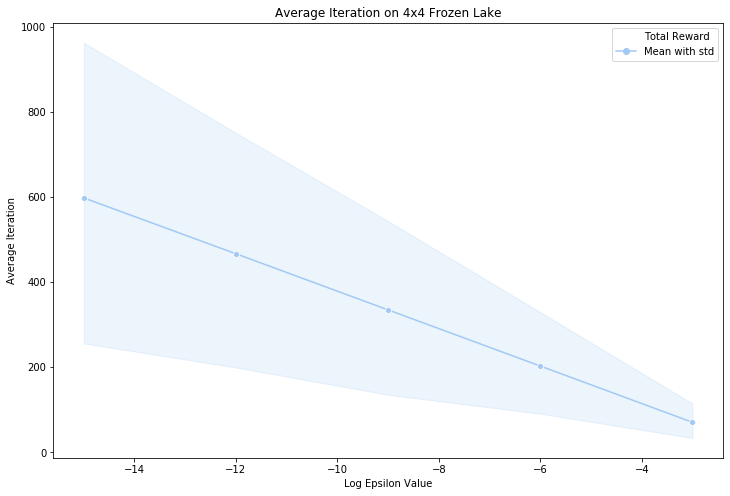

In [209]:
ploting_parameters(value_grid4[4], value="Iteration", size=4, variable="Log Epsilon Value", log=True)

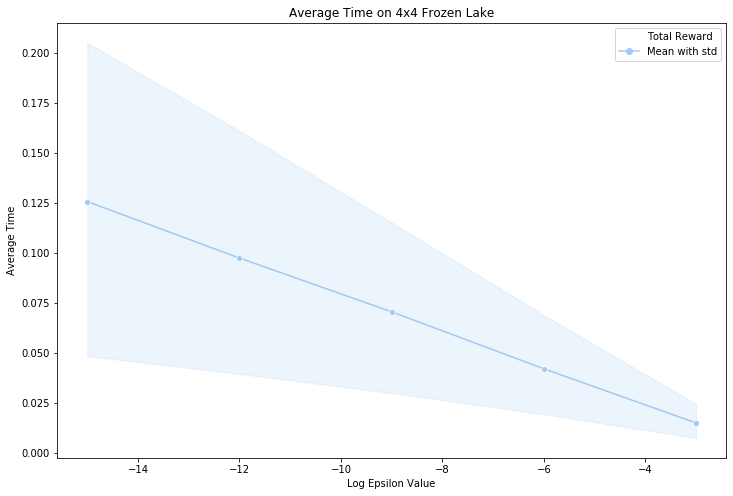

In [210]:
ploting_parameters(value_grid4[5], value="Time", size=4, variable="Log Epsilon Value", log=True)

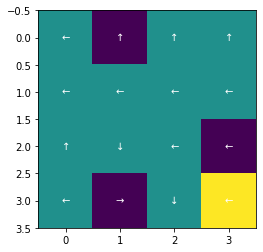

In [123]:
pol = pi_dic[0.99][1e-12]['policy']
policy_grid4 = normalize_dict(pi_dic)
grid_policy_visualizer(4, pol)

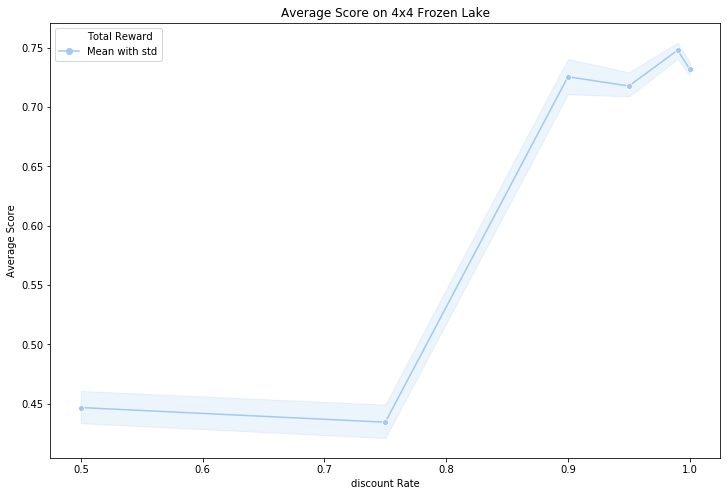

In [214]:
ploting_parameters(policy_grid4[0], value="Score", size=4)

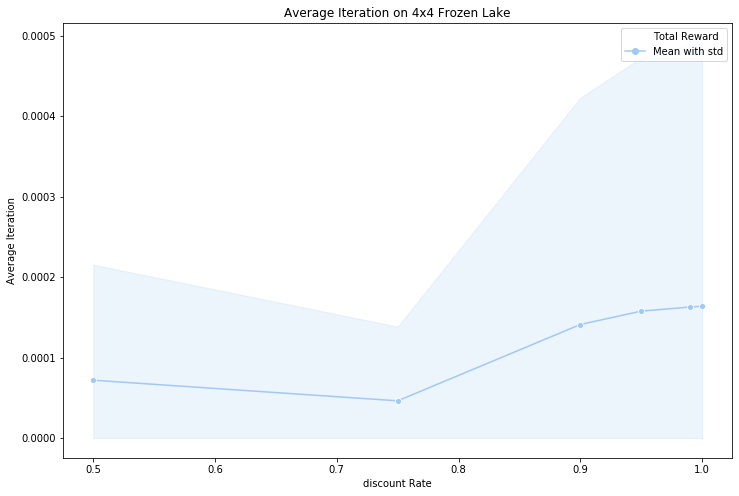

In [215]:
ploting_parameters(policy_grid4[1], value="Iteration", size=4)

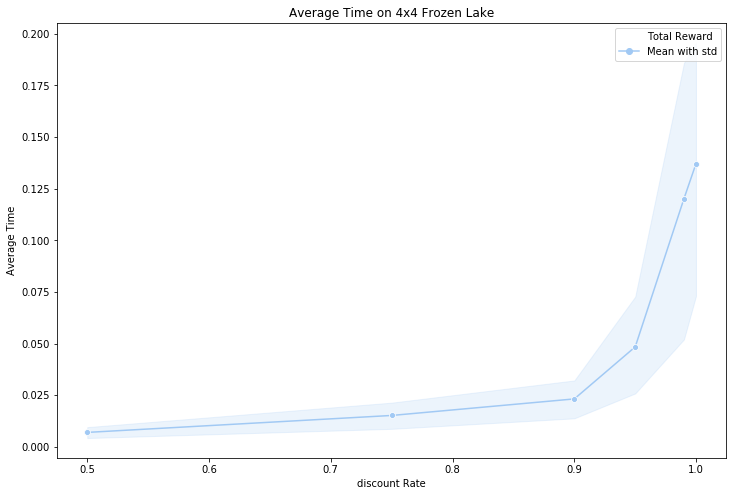

In [216]:
ploting_parameters(policy_grid4[2], value="Time", size=4)

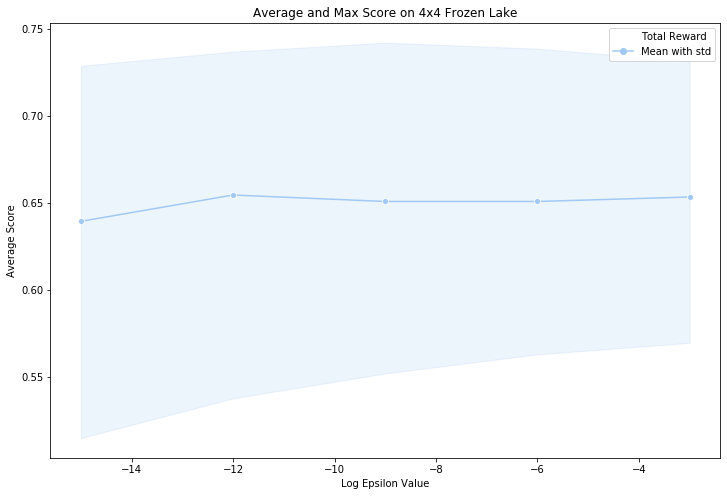

In [195]:
ploting_parameters(policy_grid4[3], value="Score", size=4, variable="Log Epsilon Value", log=True)

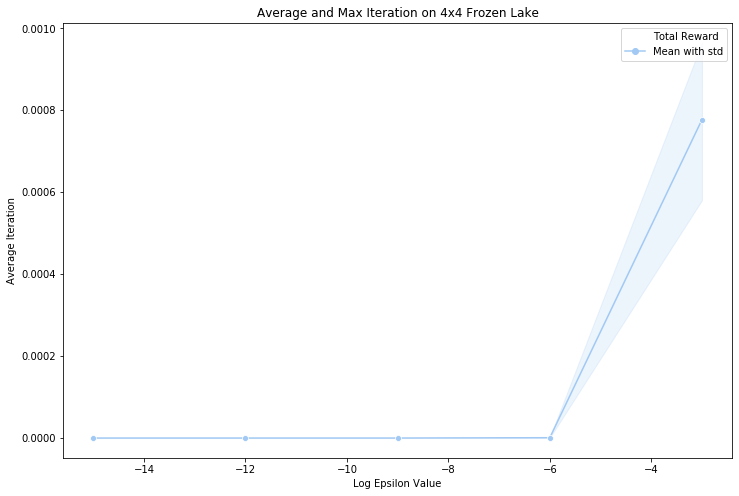

In [196]:
ploting_parameters(policy_grid4[4], value="Iteration", size=4, variable="Log Epsilon Value", log=True)

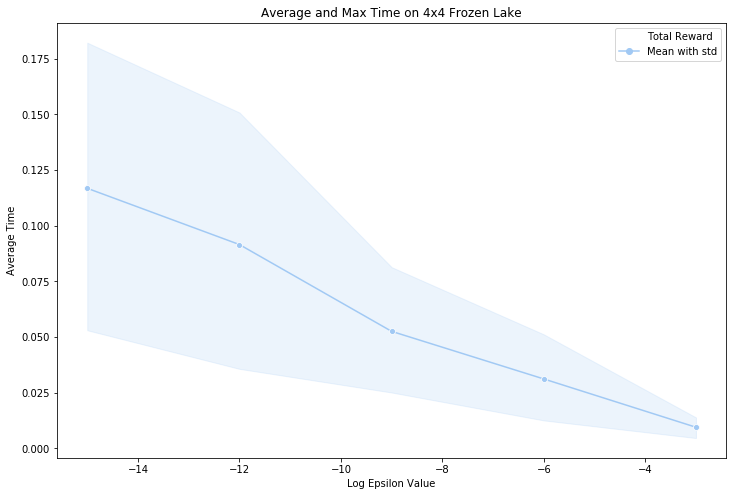

In [197]:
ploting_parameters(policy_grid4[5], value="Time", size=4, variable="Log Epsilon Value", log=True)

## 16 x 16

In [130]:
environment = FrozenLakeEnv(desc=GRIDS["16x16"])
value_dic_16, policy_dic_16 = run_pi_vi_policy(environment, disc=[0.5, 0.75, 0.9, 0.95, 0.99, 0.9999], 
                                          epsilon=[1e-3, 1e-6, 1e-9, 1e-12, 1e-15], verbose=True)

converged in: 8 episodes and 0:00:00.022751 seconds
converged in: 17 episodes and 0:00:00.043837 seconds
converged in: 26 episodes and 0:00:00.071500 seconds
converged in: 36 episodes and 0:00:00.094832 seconds
converged in: 46 episodes and 0:00:00.124167 seconds
converged in: 15 episodes and 0:00:00.038293 seconds
converged in: 36 episodes and 0:00:00.094692 seconds
converged in: 59 episodes and 0:00:00.163184 seconds
converged in: 82 episodes and 0:00:00.220085 seconds
converged in: 104 episodes and 0:00:00.274356 seconds
converged in: 32 episodes and 0:00:00.082916 seconds
converged in: 89 episodes and 0:00:00.242498 seconds
converged in: 142 episodes and 0:00:00.366452 seconds
converged in: 192 episodes and 0:00:00.493544 seconds
converged in: 241 episodes and 0:00:00.652426 seconds
converged in: 56 episodes and 0:00:00.144405 seconds
converged in: 153 episodes and 0:00:00.397558 seconds
converged in: 237 episodes and 0:00:00.598700 seconds
converged in: 319 episodes and 0:00:00.83

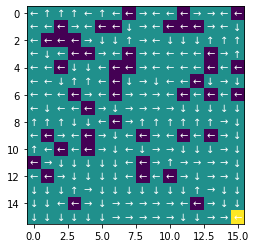

In [131]:
pol = value_dic_16[0.9999][1e-15]['policy']
value_grid16 = normalize_dict(value_dic_16)
grid_policy_visualizer(16, pol)

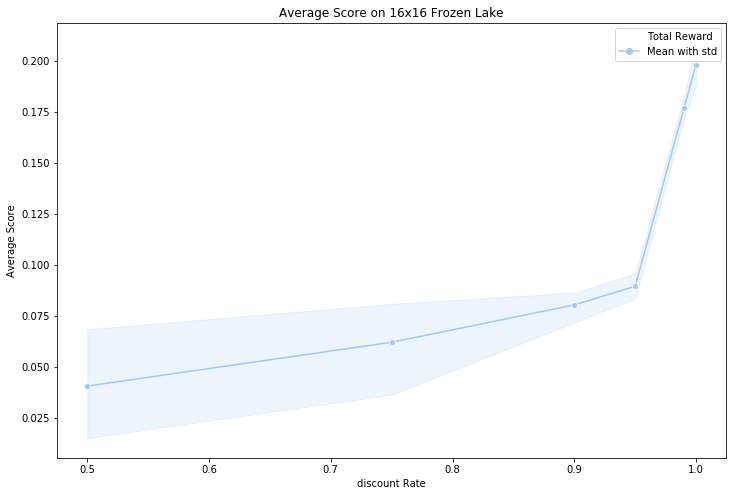

In [211]:
ploting_parameters(value_grid16[0], value="Score", size=16)

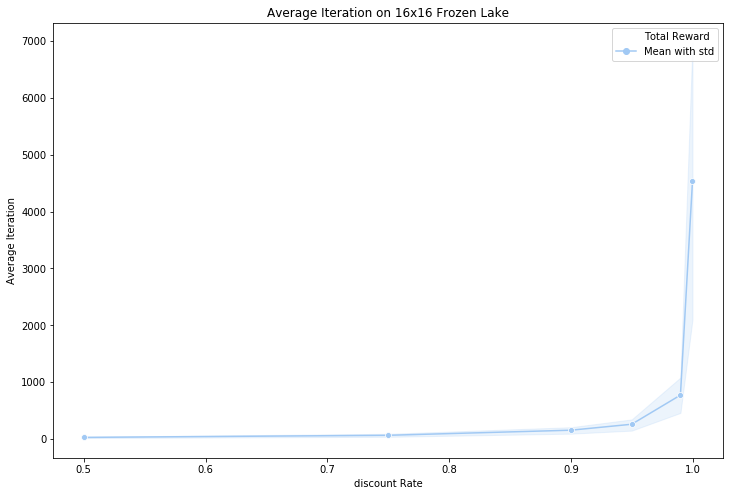

In [212]:
ploting_parameters(value_grid16[1], value="Iteration", size=16)

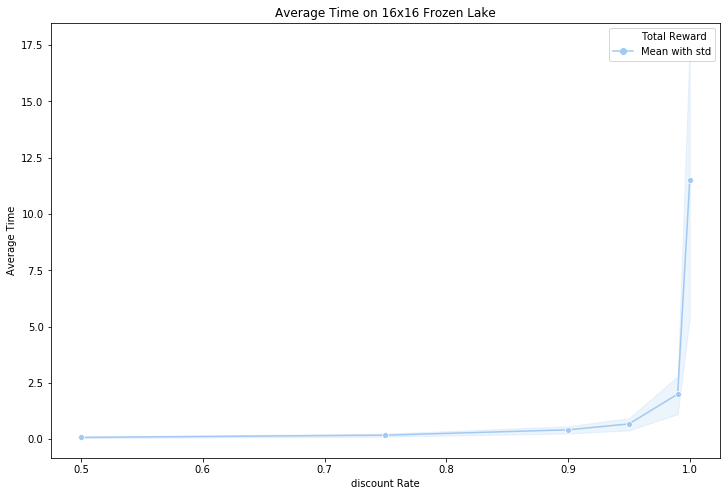

In [213]:
ploting_parameters(value_grid16[2], value="Time", size=16)

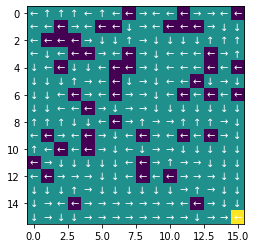

In [217]:
pol = policy_dic_16[0.99][1e-12]['policy']
grid_policy_visualizer(16, pol)

In [135]:
policy_iteration_16 = normalize_dict(policy_dic_16)

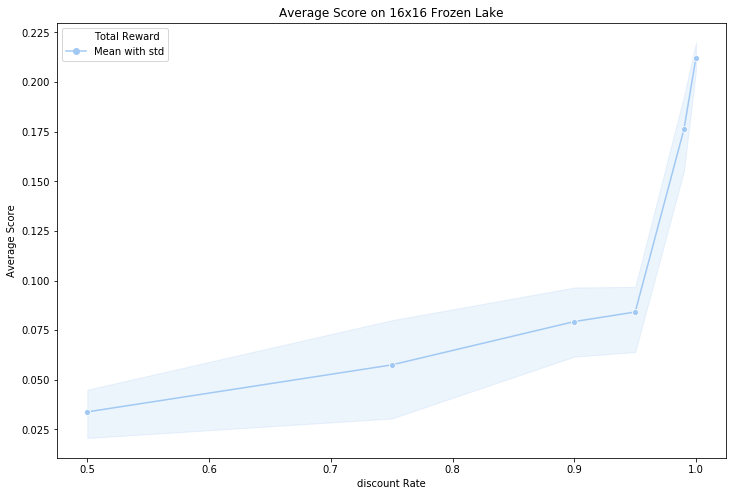

In [218]:
ploting_parameters(policy_iteration_16[0], value="Score", size=16)

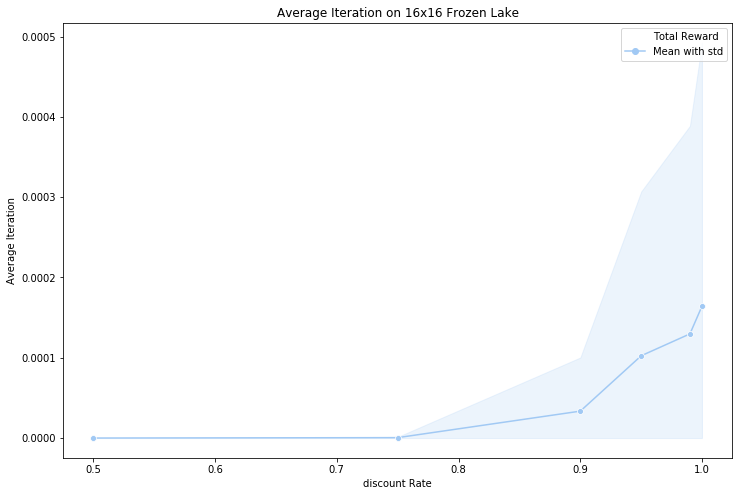

In [219]:
ploting_parameters(policy_iteration_16[1], value="Iteration", size=16)

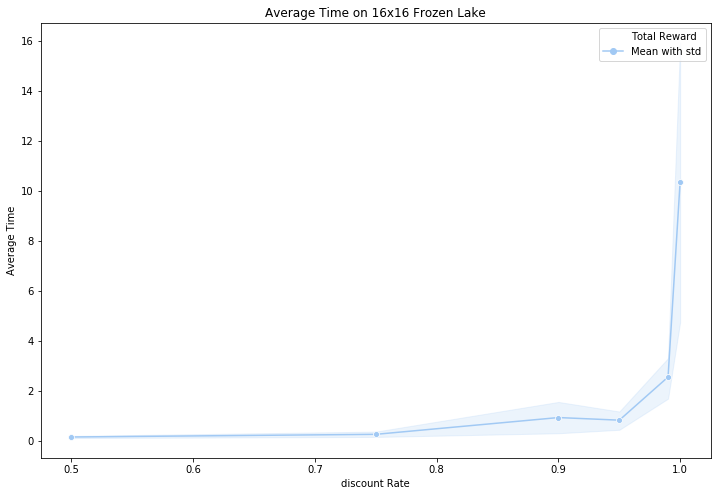

In [220]:
ploting_parameters(policy_iteration_16[2], value="Time", size=16)

In [139]:
# q learning 


In [140]:
def q_learner(environment, disc=0.9, total_eps=1e5, alpha=0.1, decay_rate=None,
               min_epsilon=0.01):
    
    start = timer()
    
    num_states = environment.observation_space.n
    num_action = environment.action_space.n
    
    qtable = np.zeros((num_states, num_action))
    lr = alpha
    gamma = disc

    epsilon = 1.0
    max_epsilon = 1.0
    min_epsilon = 0.01
    
    if not decay_rate:
        decay_rate = 1./total_eps
    
    rewards = []
    for eps in range(int(total_eps)):
        # reset the environmentironment
        state = environment.reset()
        step = 0
        done = False
        total_reward = 0
        while True:

            exploitation_tradeoff= random.uniform(0,1)

            if exploitation_tradeoff> epsilon:
                b = qtable[state, :]
                action = np.random.choice(np.where(b == b.max())[0])

            else:
                action = environment.action_space.sample()

            # take action (a) and observe the outcome state (s') and reward (r)    
            new_s, reward, done, info = environment.step(action)
            total_reward += reward
            # update Q(s,a) := Q(s,a) + lr [R(s,a) + gamma * max(Q (s', a') - Q(s,a))]
            if not done:
                qtable[state, action] = qtable[state, action] + lr*(reward + gamma*np.max(qtable[new_s, :]) - qtable[state, action])
            else:
                qtable[state, action] = qtable[state,action] + lr*(reward - qtable[state,action])

            # change state
            state = new_s

            # is it Done
            if done:
                break
                
        # reduce epsilon 
        rewards.append(total_reward)
        epsilon = max(max_epsilon -  decay_rate * eps, min_epsilon) 
    #     print (epsilon)
    
    end = timer()
    time_spent = timedelta(seconds=end-start)
    print("converged in: {} eps and {} seconds".format(total_eps, time_spent))
    return np.argmax(qtable, axis=1), total_eps, time_spent, qtable, rewards

In [141]:
def run_q_learner(environment, disc=[0.9], total_eps=[1e5], alphas=[0.1], decay_rates=[0.01], mute=False):
    
    min_epsilon = 0.01
    
    q_dict = {}
    for dis in disc:
        q_dict[dis] = {}
        for eps in total_eps:
            q_dict[dis][eps] = {}
            for alpha in alphas:
                q_dict[dis][eps][alpha] = {}
                for dr in decay_rates:
                    q_dict[dis][eps][alpha][dr] = {}
                    

                    q_policy, q_iter_solved, q_time_taken, q_table, rewards = q_learner(environment, dis, eps, alpha, dr, min_epsilon)
                    q_avg_rewards, q_avg_eps, _, __ = policy_check(environment, q_policy)
                    q_dict[dis][eps][alpha][dr]["avg_reward"] = q_avg_rewards
                    q_dict[dis][eps][alpha][dr]["avg_eps"] = q_avg_eps
                    q_dict[dis][eps][alpha][dr]["q-table"] = q_table
                    q_dict[dis][eps][alpha][dr]["rewards"] = rewards 
                    q_dict[dis][eps][alpha][dr]["iteration"] = q_iter_solved
                    q_dict[dis][eps][alpha][dr]["time_spent"] = q_time_taken
                    q_dict[dis][eps][alpha][dr]["policy"] = q_policy
                    if not mute:
                        print("gamma: {} total_eps: {} lr: {}, dr: {}".format(dis, eps, alpha, dr))
                        print("Iteration: {} time: {}".format(q_iter_solved, q_time_taken))
                        print("Average reward: {} - average episodes: {}".format(q_avg_rewards, q_avg_eps))
    return q_dict

In [142]:
def dic_2_dataframe(the_dict):
    the_df = pd.DataFrame(columns=["disc Rate", "Training epss", "Learning Rate", 
                                   "Decay Rate", "Reward", "Time Spent"])
    for dis in the_dict:
        for eps in the_dict[dis]:
            for lr in the_dict[dis][eps]:
                for dr in the_dict[dis][eps][lr]:
                    rew = the_dict[dis][eps][lr][dr]["avg_reward"]
                    time_spent = the_dict[dis][eps][lr][dr]["time_spent"].total_seconds()
                    dic = {"disc Rate": dis, "Training epss": eps, "Learning Rate":lr, 
                           "Decay Rate":dr, "Reward": rew, "Time Spent": time_spent}
                    the_df = the_df.append(dic, ignore_index=True)
    return the_df

In [143]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [144]:
environment = gym.make('FrozenLake-v0')
eps = [1e4, 1e5, 1e6]
decays = [1e-6]

q_dict = run_q_learner(environment, disc=[0.75, 0.9, 0.99, 0.9999], total_eps=eps,
                          alphas=[0.01, 0.1], decay_rates=decays)

converged in: 10000.0 eps and 0:00:02.549032 seconds
gamma: 0.75 total_eps: 10000.0 lr: 0.01, dr: 1e-06
Iteration: 10000.0 time: 0:00:02.549032
Average reward: 0.167 - average episodes: 18.78
converged in: 10000.0 eps and 0:00:02.316445 seconds
gamma: 0.75 total_eps: 10000.0 lr: 0.1, dr: 1e-06
Iteration: 10000.0 time: 0:00:02.316445
Average reward: 0.124 - average episodes: 13.705
converged in: 100000.0 eps and 0:00:24.078168 seconds
gamma: 0.75 total_eps: 100000.0 lr: 0.01, dr: 1e-06
Iteration: 100000.0 time: 0:00:24.078168
Average reward: 0.41 - average episodes: 26.224
converged in: 100000.0 eps and 0:00:23.924331 seconds
gamma: 0.75 total_eps: 100000.0 lr: 0.1, dr: 1e-06
Iteration: 100000.0 time: 0:00:23.924331
Average reward: 0.05 - average episodes: 9.166
converged in: 1000000.0 eps and 0:07:20.744208 seconds
gamma: 0.75 total_eps: 1000000.0 lr: 0.01, dr: 1e-06
Iteration: 1000000.0 time: 0:07:20.744208
Average reward: 0.436 - average episodes: 28.513
converged in: 1000000.0 eps a

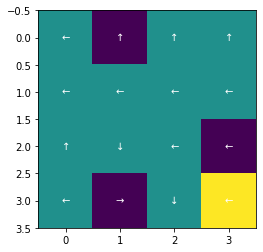

In [145]:
pol = q_dict[0.99][int(1e6)][0.1][1e-06]['policy']
grid_policy_visualizer(4, pol)

In [146]:
eps = [1e4, 1e5, 1e6]
decays = [1e-3, 1e-5]
q_dict = run_q_learner(environment, disc= [0.9999], total_eps=eps,
                          alphas=[0.1, 0.01], decay_rates=decays)

converged in: 10000.0 eps and 0:00:15.609820 seconds
gamma: 0.9999 total_eps: 10000.0 lr: 0.1, dr: 0.001
Iteration: 10000.0 time: 0:00:15.609820
Average reward: 0.64 - average episodes: 40.955
converged in: 10000.0 eps and 0:00:02.921259 seconds
gamma: 0.9999 total_eps: 10000.0 lr: 0.1, dr: 1e-05
Iteration: 10000.0 time: 0:00:02.921259
Average reward: 0.734 - average episodes: 45.104
converged in: 10000.0 eps and 0:00:03.243864 seconds
gamma: 0.9999 total_eps: 10000.0 lr: 0.01, dr: 0.001
Iteration: 10000.0 time: 0:00:03.243864
Average reward: 0.043 - average episodes: 6.475
converged in: 10000.0 eps and 0:00:02.585920 seconds
gamma: 0.9999 total_eps: 10000.0 lr: 0.01, dr: 1e-05
Iteration: 10000.0 time: 0:00:02.585920
Average reward: 0.434 - average episodes: 35.639
converged in: 100000.0 eps and 0:03:02.895767 seconds
gamma: 0.9999 total_eps: 100000.0 lr: 0.1, dr: 0.001
Iteration: 100000.0 time: 0:03:02.895767
Average reward: 0.76 - average episodes: 44.794
converged in: 100000.0 eps a

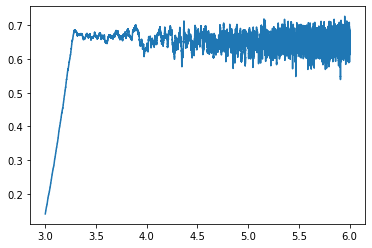

In [147]:
rewards = q_dict[0.9999][int(1e6)][0.1][1e-03]['rewards']
run = 1000
rewards_cumm = running_mean(rewards, run)
indices = [i+run for i in list(range(len(rewards_cumm)))]
sns.lineplot(np.log10(indices), rewards_cumm)

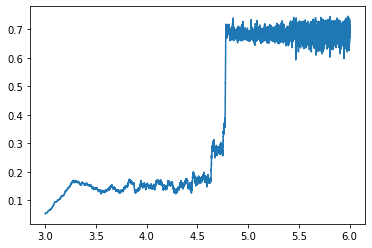

In [148]:
rewards = q_dict[0.9999][int(1e6)][0.01][1e-03]['rewards']
run = 1000
rewards_cumm = running_mean(rewards, run)
indices = [i+run for i in list(range(len(rewards_cumm)))]
sns.lineplot(np.log10(indices), rewards_cumm)

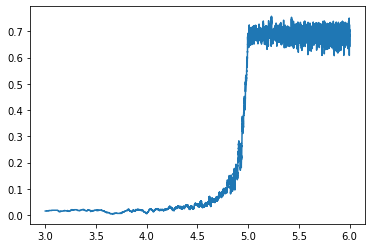

In [149]:
rewards = q_dict[0.9999][int(1e6)][0.01][1e-05]['rewards']
run = 1000
rewards_cumm = running_mean(rewards, run)
indices = [i+run for i in list(range(len(rewards_cumm)))]
sns.lineplot(np.log10(indices), rewards_cumm)

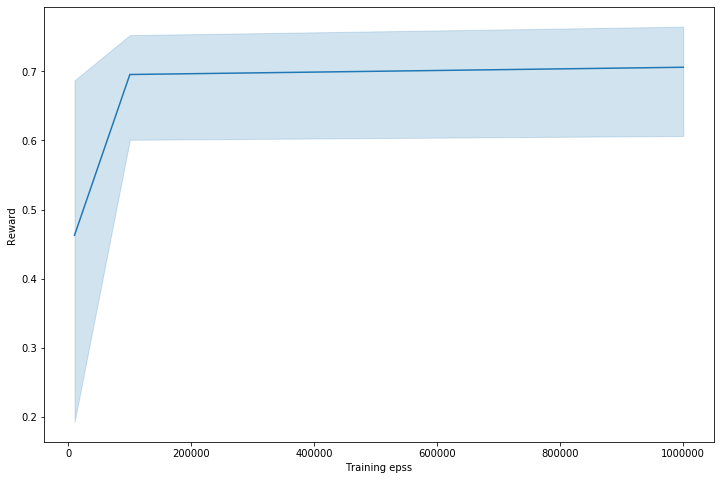

In [151]:
grid_4 = dic_2_dataframe(q_dict)
pl = sns.lineplot(x="Training episode", y="Reward", data=grid_4)
pl.figure.set_figwidth(12)
pl.figure.set_figheight(8)

In [ ]:
grid_4

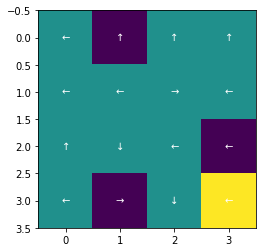

In [152]:
pol = q_dict[0.9999][int(1e6)][0.01][1e-03]['policy']
grid_policy_visualizer(4, pol)

In [ ]:
# 16*16

In [153]:
environment = FrozenLakeEnv(desc=GRIDS["16x16"])
eps = [1e4, 1e5, 1e6]
decays = [1e-3, 1e-5]
q_dict16 = run_q_learner(environment, disc= [0.9999], total_eps=eps,
                          alphas=[0.1, 0.01], decay_rates=decays)

converged in: 10000.0 eps and 0:00:04.238291 seconds
gamma: 0.9999 total_eps: 10000.0 lr: 0.1, dr: 0.001
Iteration: 10000.0 time: 0:00:04.238291
Average reward: 0.0 - average episodes: 197.091
converged in: 10000.0 eps and 0:00:03.652142 seconds
gamma: 0.9999 total_eps: 10000.0 lr: 0.1, dr: 1e-05
Iteration: 10000.0 time: 0:00:03.652142
Average reward: 0.0 - average episodes: 195.186
converged in: 10000.0 eps and 0:00:04.598318 seconds
gamma: 0.9999 total_eps: 10000.0 lr: 0.01, dr: 0.001
Iteration: 10000.0 time: 0:00:04.598318
Average reward: 0.0 - average episodes: 194.367
converged in: 10000.0 eps and 0:00:03.588398 seconds
gamma: 0.9999 total_eps: 10000.0 lr: 0.01, dr: 1e-05
Iteration: 10000.0 time: 0:00:03.588398
Average reward: 0.0 - average episodes: 210.193
converged in: 100000.0 eps and 0:00:44.018704 seconds
gamma: 0.9999 total_eps: 100000.0 lr: 0.1, dr: 0.001
Iteration: 100000.0 time: 0:00:44.018704
Average reward: 0.0 - average episodes: 200.51
converged in: 100000.0 eps and 

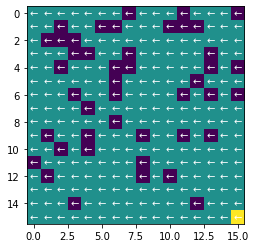

In [154]:
pol = q_dict16[0.9999][int(1e6)][0.1][1e-05]['policy']
grid_policy_visualizer(16, pol)

In [155]:
(q_dict16[0.9999][int(1e6)][0.1][1e-05]['q-table'] > 0).any()

False

In [156]:
grid_16 = dic_2_dataframe(q_dict16)
grid_16 

,disc Rate,Training epss,Learning Rate,Decay Rate,Reward,Time Spent
0,0.9999,10000.0,0.10,0.00100,0.0,4.238291
1,0.9999,10000.0,0.10,0.00001,0.0,3.652142
2,0.9999,10000.0,0.01,0.00100,0.0,4.598318
3,0.9999,10000.0,0.01,0.00001,0.0,3.588398
4,0.9999,100000.0,0.10,0.00100,0.0,44.018704
5,0.9999,100000.0,0.10,0.00001,0.0,38.647449
6,0.9999,100000.0,0.01,0.00100,0.0,44.280486
7,0.9999,100000.0,0.01,0.00001,0.0,39.101087
8,0.9999,1000000.0,0.10,0.00100,0.0,436.612554
9,0.9999,1000000.0,0.10,0.00001,0.0,428.227726
